<a href="https://colab.research.google.com/github/mtablado/uoc2022_tfm/blob/main/MRI-loading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad
import numpy as np
import math

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# añade el path a tu directorio
%cd /content/drive/My Drive/tfm/dataset/IXI-T1

/content/drive/My Drive/tfm/dataset/IXI-T1


In [16]:
import glob
import nibabel as nib #reading MR images

from matplotlib import pyplot as plt
%matplotlib inline

In [17]:
ff = glob.glob('./*')
ff[0]

'./IXI023-Guys-0699-T1.nii.gz'

In [18]:
len(ff[0])

28

In [19]:
def extract_slices(ff):
  images = []
  #for f in range(len(ff)):
  files = (0, 1)
  for f in files:
    print(ff[f])
    a = nib.load(ff[f])
    a = a.get_fdata()
    a = a[:,78:129,:]
    for i in range(a.shape[1]):
      images.append((a[:,i,:]))
  return images

  
images = extract_slices(ff)
image = images[1]

#image = nib.load(ff[0])
#image = image.get_fdata()

print (image.shape)

./IXI023-Guys-0699-T1.nii.gz
./IXI024-Guys-0705-T1.nii.gz
(256, 130)


In [20]:
print(len(images))
print(images[1].shape)
print(type(image))

102
(256, 130)
<class 'numpy.ndarray'>


In [21]:
print(image[100,50])

806.2262964248657


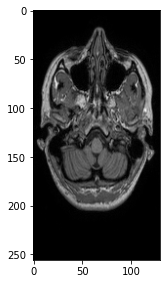

In [22]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
#img = image[:,:,100]
plt.imshow(image, cmap='gray')



In [43]:
import matplotlib
import random

def save_slices(images):
  # Shuffle images to be stored randomly on training, validation and test dirs
  random.shuffle(images)

  total = len(images)
  print(total)
  for i, image in enumerate(images):
    name = str(i) + '.png'
    if (i > 0.8 * total):
      name = 'test/' + name
    elif (i > 0.6 * total):
      name = 'validation/' + name
    else:
      name = 'training/' + name
    
    matplotlib.image.imsave(name, image, cmap='gray')

# añade el path a tu directorio
%cd /content/drive/My Drive/tfm/dataset/images
try:
  os.mkdir('/content/drive/My Drive/tfm/dataset/images/training', mode=644)
  os.mkdir('/content/drive/My Drive/tfm/dataset/images/validation', mode=644)
  os.mkdir('/content/drive/My Drive/tfm/dataset/images/test', mode=644)
except:
  print('directories already exist')
save_slices(images)

/content/drive/My Drive/tfm/dataset/images
directories already exist
102


In [24]:
def encoder():

  img_shape = (256, 256, 3)
  batch_size = 16
  # Dimensionality of the latent space: a 2D plane
  latent_dim = 2

  input_img = keras.Input(shape=img_shape)

  x = layers.Conv2D(32, 3,
                    padding='same', activation='relu')(input_img)
  x = layers.Conv2D(64, 3,
                    padding='same', activation='relu',
                    strides=(2, 2))(x)
  x = layers.Conv2D(64, 3,
                    padding='same', activation='relu')(x)
  x = layers.Conv2D(64, 3,
                    padding='same', activation='relu')(x)
  shape_before_flattening = K.int_shape(x)

  x = layers.Flatten()(x)
  x = layers.Dense(32, activation='relu')(x)

  # The input image ends up being encoded into these two parameters.
  z_mean = layers.Dense(latent_dim)(x)
  z_log_var = layers.Dense(latent_dim)(x)
  return input_img, shape_before_flattening, z_mean, z_log_var

In [25]:
def decoder(shape_before_flattening, z):
  # Input where you’ll feed z
  decoder_input = layers.Input(K.int_shape(z)[1:])

  # Upsamples the input
  x = layers.Dense(np.prod(shape_before_flattening[1:]),
                  activation='relu')(decoder_input)

  # Reshapes z into a feature map of the same shape as the feature map 
  # just before the last Flatten layer in the encoder model
  x = layers.Reshape(shape_before_flattening[1:])(x)

  # Uses a Conv2DTranspose layer and Conv2D layer to decode z 
  # into a feature map the same size as the original image input
  x = layers.Conv2DTranspose(32, 3,
                            padding='same',
                            activation='relu',
                            strides=(2, 2))(x)
  x = layers.Conv2D(1, 3,
                    padding='same',
                    activation='sigmoid')(x)

  # Instantiates the decoder model, which turns “decoder_input” into the decoded image
  decoder = Model(decoder_input, x)

  # Applies it to z to recover the decoded z
  z_decoded = decoder(z)
  return z_decoded



In [26]:
# Encodes the input into a mean and variance parameter
input_img, shape_before_flattening, z_mean, z_log_variance = encoder()

# Create a random tensor of small values
epsilon_shape =(1, 2)
epsilon = tf.random.uniform(epsilon_shape, minval=0, maxval=0.1, seed=32)

x = tf.keras.backend.exp(z_log_variance)

# Draws a latent point using a small random epsilon
z = z_mean + x * epsilon

# Decodes z back to an image
reconstructed_img = decoder(shape_before_flattening, z)

#plt.imshow(reconstructed_img, cmap='gray')

# Instantiates the autoencoder model, which maps an input image to its reconstruction
model = Model(input_img, reconstructed_img)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  18496       ['conv2d[0][0]']                 
                                )                                                           

In [27]:
def ELBOloss(y_true, y_pred):
  # The reconstruction loss measures how close the decoder output is to the original input by using the mean-squared error (MSE)
  reconstruction_loss = keras.metrics.mean_squared_error(y_true, y_pred)

  # The KL loss, or Kullback–Leibler divergence, measures the difference between two probability distributions. Minimizing the KL loss in this case means ensuring that the learned means and variances are as close as possible to those of the target (normal) distribution. For a latent dimension of size K
  kl = tf.keras.losses.KLDivergence()
  kl_loss = kl(y_true, y_pred).numpy()

  # Combined loss
  return reconstruction_loss + kl_loss



In [28]:
import os
%cd /content/drive/My\ Drive/tfm/dataset/images/

path = os.path.curdir
training_path = os.path.join(path, 'training')

print(training_path)
vaidation_path = os.path.join(path, 'validation')
test_path = os.path.join(path, 'test')

train_ds = keras.preprocessing.image_dataset_from_directory(
    training_path)
valid_ds = keras.preprocessing.image_dataset_from_directory(
    vaidation_path,
    labels=None)
test_ds = keras.preprocessing.image_dataset_from_directory(
    test_path,
    labels=None)

/content/drive/My Drive/tfm/dataset/images
./training
Found 62 files belonging to 1 classes.
Found 40 files belonging to 1 classes.
Found 40 files belonging to 1 classes.


In [29]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [44]:
def vae_encoder():
  latent_dim = 2

  encoder_inputs = keras.Input(shape=(256, 256, 1))
  x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
  x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(16, activation="relu")(x)
  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])
  encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
  encoder.summary()
  return encoder

my_encoder = vae_encoder()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 128, 128, 32  320         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_8 (Conv2D)              (None, 64, 64, 64)   18496       ['conv2d_7[0][0]']               
                                                                                            

In [45]:
def vae_decoder():
  latent_dim = 2
  latent_inputs = keras.Input(shape=(latent_dim,))
  x = layers.Dense(64 * 64 * 64, activation="relu")(latent_inputs)
  x = layers.Reshape((64, 64, 64))(x)
  x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
  x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
  decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
  decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
  decoder.summary()
  return decoder

my_decoder = vae_decoder()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_9 (Dense)             (None, 262144)            786432    
                                                                 
 reshape_4 (Reshape)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 128, 128, 64)     36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 256, 256, 32)     18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 256, 256, 1)      289 

In [46]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [47]:
%cd /content/drive/My Drive/tfm/dataset/images
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'training',
        target_size=(150, 150),
        batch_size=32,
        class_mode=None)


/content/drive/My Drive/tfm/dataset/images
Found 62 images belonging to 1 classes.


In [48]:
import timeit
vae = VAE(my_encoder, my_decoder)
vae.compile(
    optimizer=keras.optimizers.Adam())

# Entrenar el modelo
t0 = timeit.default_timer()
print(train_ds.class_names)

mfit = vae.fit(train_generator, epochs=30, batch_size=62)
training_time_ann = timeit.default_timer() - t0

['t1']
Epoch 1/30


UnimplementedError: ignored

In [ ]:
import timeit


# Compile
model.compile(
    optimizer=Adam(learning_rate=0.01), 
    loss=ELBOloss, 
    metrics=[keras.metrics.BinaryAccuracy()],
    run_eagerly=True
)  
# Entrenar el modelo
t0 = timeit.default_timer()
mfit = model.fit(train_ds, epochs=20, batch_size=128, validation_data=valid_ds)
training_time_ann = timeit.default_timer() - t0

In [ ]:
y_pred = model.predict(test_ds)


In [ ]:
fig, axes = plt.subplots(1, len(y_pred), figsize=(25,25))

for i in range(len(y_pred)):
  image = y_pred[1]
  image = image[:,:,0]
  axes[i].imshow(image, cmap="gray", origin="lower")
  # Display the first image in training data
  #img = image[:,:,100]
  plt.imshow(image, cmap='gray')

In [ ]:
def sampling(args):
  latent_dim = 2
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                            mean=0., stddev=1.)
  return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_variance])


In [ ]:
f, big_axes = plt.subplots(15,10, figsize=(25,25))

for i in range(0,15):
  for j in range(0,10):
    slice_position = ((i - 1) * 10) + j
    big_axes[i,j].imshow(image[:,:,slice_position], cmap='gray')


